## Image segmentation test

In [1]:
import sys
import cv2
import time
import colorsys
import random
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

2021-07-30 14:46:31.236610: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-07-30 14:46:31.236642: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [25]:
model = tf.keras.models.load_model('../models/bestDB/128x128_acc_0.9471_loss_0.0605_val-acc_0.9476_val-loss_0.0586_0.22M_29-07-21-DB-best/')

In [26]:
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
sequential_47 (Sequential)      (None, 64, 64, 16)   432         input_8[0][0]                    
__________________________________________________________________________________________________
sequential_48 (Sequential)      (None, 32, 32, 32)   4672        sequential_47[0][0]              
__________________________________________________________________________________________________
sequential_49 (Sequential)      (None, 16, 16, 64)   18560       sequential_48[0][0]              
____________________________________________________________________________________________

In [27]:
def random_colors(N, bright=True):
    brightness = 1.0 if bright else 0.7
    hsv = [(i / N, 1, brightness) for i in range(N)]
    colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
    return colors


def apply_mask(image, mask, color, alpha=0.5):
#     if image.shape[:2] != mask.shape:
#         h, w, _ = image.shape
#         mask = cv2.resize(mask, (w, h), cv2.INTER_LINEAR)
    """Apply the given mask to the image"""
    for c in range(3):
        image[:, :, c] = np.where(mask == 1,
                                  image[:, :, c] *
                                  (1 - alpha) + alpha * color[c] * 255,
                                  image[:, :, c])
    return image

def colorCast(img):
    ''' Takes a raw image as input and reduces the saturation of GREEN channel'''
    rng = np.array([0, 32, 64, 96, 128, 160, 192, 224, 255])
    norm_rng = rng / (2000 /(1 + 5))
    exprng = np.exp(norm_rng)
    exprng = 255 * ((exprng - exprng.max()) / (exprng.max() - exprng.min()) + 1)
    # Create a LookUp Table
    fullRange = np.arange(0, 256)
    gLUT = np.interp(fullRange, rng, exprng)

    # Get the green channel and apply the mapping
    gChannel = img[:, :, 1]
    gChannel = cv2.LUT(gChannel, gLUT)
    img[:, :, 1] = gChannel
    return img

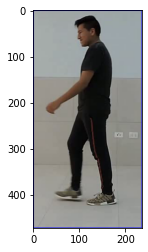

In [28]:
img = cv2.imread('../data/silhuette.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

In [29]:
# width, height = 160, 160
width, height = 128, 128

def inference(img):
    start = time.time()
#     img = colorCast(img)
#     img = frame[50:200,230:,::-1]
    tf_image = tf.image.resize(tf.convert_to_tensor(np.array(img)),(width, height))/255
    output = model.predict(tf.expand_dims(tf_image, 0))
#     output = model.predict(tf.stack([tf_image, tf_image, tf_image, tf_image, tf_image]))
    out = np.where(output[0,:,:,0]>0.2, 1, 0)
    end = time.time()
    print(end - start)
    return out
#     plt.figure(figsize=(10,10))
#     plt.imshow(out, 'gray')
#     plt.show()

0.03883051872253418


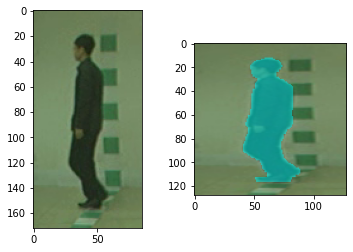

In [31]:
hog = cv2.HOGDescriptor() 
hog.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())


# cap = cv2.VideoCapture('../data/videos/001-nm-01-090.avi')
cap = cv2.VideoCapture('/home/israel/Downloads/CASIA/DatasetB-1/video/001-nm-02-090.avi')

# cap = cv2.VideoCapture('/home/israel/Downloads/3.mp4')
cap.set(cv2.CAP_PROP_POS_FRAMES, 90)
ret, frame = cap.read()
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
regions, _ = hog.detectMultiScale(frame, winStride=(8, 8)) 
for (x, y, w, h) in regions: 
    roi = frame[y:y+h, x:x+w]
color = random_colors(2)
roi_resized = cv2.resize(roi, (width, height), cv2.INTER_LINEAR)
pred = inference(roi)
out = apply_mask(roi_resized, pred, color[-1])
plt.subplot(121); plt.imshow(roi); 
plt.subplot(122); plt.imshow(out);
cap.release()

In [15]:
hog = cv2.HOGDescriptor() 
hog.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())

# frame_height, frame_width,_ = frame.shape
# out_cap = cv2.VideoWriter('CASIA_dataset.avi',cv2.VideoWriter_fourcc('M','J','P','G'), 10, (frame_width,frame_height))


# cap = cv2.VideoCapture('../data/videos/001-nm-01-090.avi')
# cap = cv2.VideoCapture('/home/israel/Downloads/s1_ucb.mp4')
# cap = cv2.VideoCapture(0)
cap = cv2.VideoCapture('/home/israel/Downloads/CASIA/DatasetB-1/video/033-nm-02-090.avi')
roi = np.zeros((100,100))
color = random_colors(2)

cv2.namedWindow('roi', cv2.WINDOW_NORMAL)
nframe = 0
start = time.time()
fps = 30
while(cap.isOpened()):
    ret, frame = cap.read()
    if ret:
#         copied = cv2.resize(frame, (0, 0), fx=0.25, fy=0.25)
        copied = frame.copy()
        regions, _ = hog.detectMultiScale(copied, winStride=(8, 8)) 
        for (x, y, w, h) in regions: 
            roi = copied[y:y+h, x:x+w]
            roi_resized = cv2.resize(roi, (width, height), cv2.INTER_LINEAR)
            if nframe%1 == 0:
                roi_rgb = cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)
                pred = inference(roi_rgb)
#             pred = lite_inference(roi)
            out = apply_mask(roi_resized, pred, color[1])
            copied[y:y+h, x:x+w] = cv2.resize(out, (w, h), cv2.INTER_LINEAR)
#             cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 0, 255), 2) 
            
#         cv2.imshow('test', frame)
        
        cv2.putText(copied, "fps: {:.2f}".format(fps), (5, 20), cv2.FONT_ITALIC, 0.5, (255, 0, 0))
        cv2.imshow('roi', copied)
#         out_cap.write(copied)
        nframe +=1
        end = time.time()
        fps = nframe/(end - start)
    else:
        break
    if cv2.waitKey(30) == ord('q'):
        break
        
cap.release()
# out_cap.release()
cv2.destroyAllWindows()

0.0711970329284668
0.058617591857910156
0.049292802810668945
0.039045095443725586
0.04522299766540527
0.04479813575744629
0.05504870414733887
0.04783034324645996
0.0516049861907959
0.05643796920776367
0.04646468162536621
0.04538440704345703
0.05383729934692383
0.05384659767150879
0.05347704887390137
0.0460200309753418
0.0555262565612793
0.04562234878540039
0.03375387191772461
0.03656792640686035
0.04665327072143555
0.04588961601257324
0.03214144706726074
0.04759645462036133
0.041716814041137695
0.04623293876647949
0.04359102249145508
0.05466651916503906
0.046544551849365234
0.042566776275634766
0.03991103172302246
0.05819225311279297
0.0544888973236084
0.04463458061218262
0.04535079002380371
0.05275893211364746
0.05372953414916992
0.04558873176574707
0.05363655090332031
0.051761627197265625
0.04531383514404297
0.042214155197143555
0.045021772384643555
0.04347562789916992
0.04059791564941406
0.04625439643859863
0.0536956787109375
0.05743861198425293
0.04596281051635742
0.045279264450073

In [ ]:
cv2.destroyAllWindows()